# Boosting für Machine Learning

Wir beschäftigen uns mit den grundlegenden Varianten des sogenannten _Boostings_.
Dabei legen wir unser Augenmerk auf Boosting für die Klassifikation.
Insbesondere klassifizieren wir Reden von deutschen Politikern, d.h. aus einem gegebenen Redetext ermitteln wir wer diese Rede hielt.
(Diese Problemstellung war bereits Thema im den Übungen des [codecentric.AI](https://www.codecentric.de/kuenstliche-intelligenz/) Bootcamp zum Thema [Natural Language Processing](https://www.youtube.com/watch?v=GmLsb-o7hvM).)

_Angenommen für unser Problem steht ein schlechter Klassifikator L zur Verfügung._
_Wie können wir aus K einen guten Klassifikator L erzeugen?_

Unter einem schlechten Klassifikator verstehen wir einen Klassifikator mit schlechter Vorhersagekraft, d.h. er macht viele Fehler.
(Die Theorie erlaubt sogar so viele Fehler, dass die Kraft nur wenig besser als zufälliges Raten ist!)
Der neue Klassifikator L wird keine abgewandelte Form von K sein, sondern L besteht aus mehreren geschickt kombinierten Instanzen von K.
Daher bezeichnet man L auch als _Ensemble_.

Ensembles lassen sich für unterschiedliche zugrunde liegende Typen von Klassifikatoren erstellen.
Hier beschränken wir uns auf den Fall, dass K ein einfacher [Entscheidungsbaum-Klassifikator](https://en.wikipedia.org/wiki/Decision_tree_learning) ist.
Die Klassifikation des Ensembles L ergibt sich aus den individuellen Klassifikationen der beteiligten Entscheidungsbäume.

## Daten laden

Werfen wir zuerst einen Blick auf die Daten.
Wir verwenden den von Barbaresi und Adrien bereitgestellten Datensatz [1], der unter der URL [2] verfügbar ist.

[1] Barbaresi, Adrien (2018). "A corpus of German political speeches from the 21st century", Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018), European Language Resources Association (ELRA), pp. 792–797.

[2] http://purl.org/corpus/german-speeches

Hier ein Einblick in wenige zufällig ausgewählte Reden.

In [1]:
%run define_load_data_functions.ipynb

df = load_data()

display(df.sample(n=len(df)).head())

,person,speech
265,Christina Weiss,Sie kennen alle das wunderbare Bonmot von Osca...
82,Christina Weiss,es zeichnet die aktuelle Kunst seit einiger Ze...
1241,Angela Merkel,"der erste Jahresempfang – ich glaube, daraus s..."
1465,Angela Merkel,"liebe Kollegen aus den Parlamenten,\nherzliche..."
2258,Angela Merkel,"Vor allem: liebe Studierende, liebe Studentinn..."


Im Datensatz ist Angela Merkel mit der weitaus stärksten Anzahl von Reden vertreten.

In [2]:
speech_counts = df.person.value_counts()

display(speech_counts)

Angela Merkel              1125
Gerhard Schröder            418
Bernd Neumann               323
Monika Grütters             245
Christina Weiss             203
k.A.                         88
Michael Naumann              61
Julian Nida-Rümelin          47
Thomas de Maizière           43
Hans Martin Bury             42
Joschka Fischer              31
Rolf Schwanitz               24
Frank-Walter Steinmeier       7
Andere                        4
Jullian Nida-Rümelin          1
Name: person, dtype: int64

Wir beschränken uns auf die binäre Klassifikation, d.h. wir unterscheiden nur zwischen zwei Klassen von Personen.
Um auf ausgewogenen Daten zu arbeiten wählen wir die Klassen _Angela Merkel_ und _Nicht Angela Merkel (Andere)_.
Dazu vernachlässigen wir zuerst alle Personen, die mit nur wenigen Reden vertreten sind.

In [3]:
NUM_SPEECHES_DROP_THRESHOLD = 100
belowThreshold = lambda name: speech_counts[name] < NUM_SPEECHES_DROP_THRESHOLD

dropped = filter(belowThreshold, speech_counts.index.tolist())
df.drop(df[df.person.isin(dropped)].index, inplace=True)

display(df.person.value_counts())

Angela Merkel       1125
Gerhard Schröder     418
Bernd Neumann        323
Monika Grütters      245
Christina Weiss      203
Name: person, dtype: int64

Dann fassen wir alle verbleibenden Personen zur Klasse _Andere_ zusammen.

In [4]:
df.loc[df['person'] != "Angela Merkel", ['person']] = 'Andere'

display(df.person.value_counts())

Andere           1189
Angela Merkel    1125
Name: person, dtype: int64

Es folgt eine Vorverarbeitung der Reden mit Hilfe der NLP-Bibliothek [spaCy](https://spacy.io/).
In diesem Schritt zerlegen wir jede Rede in ihre (durch Whitespace getrennten) Bestandteile, die sogenannten _Tokens_.
Wir entfernen Tokens mit geringer Information, wie z.B. Interpunktion und Stoppwörter ("und", "der", "die", "das", ...).
Außerdem überführen wir jedes Token in seine Grundform, das sogenannte _Lemma_ (z.B. "angekündigt" -> "ankündigen").

In [7]:
%run init_spacy.ipynb
%run define_preprocessing.ipynb

df = load_cached_or_preprocess(df.speech)

display(df.head())

,person,speech,tokens,lemmata
0,Andere,"es ist angekündigt worden, man sollte im Beruf...","[angekündigt, Beruf, Schauspieler, Politiker, ...","[ankündigen, berufen, schauspielern, Politiker..."
2,Andere,Frage (Peter Hahne): Bevor wir uns über den Au...,"[Frage, Peter, Hahne, Bevor, Aufbau, Ost, Arbe...","[Frage, Peter, Hahn, bevor, Aufbau, Ost, Arbei..."
3,Andere,"Einen Satz von Ihnen, Herr Dr. Bernotat, habe ...","[Einen, Satz, Ihnen, Herr, Dr., Bernotat, aufg...","[einer, Satz, ich, Herr, Dr., Bernotat, aufsch..."
4,Andere,diese Jahresversammlung der Hochschulrektorenk...,"[Jahresversammlung, Hochschulrektorenkonferenz...","[Jahresversammlung, Hochschulrektorenkonferenz..."
5,Andere,"ich habe nie einen Hehl daraus gemacht, dass i...","[Hehl, Ihre, Stadt, komme, Es, Amtszeit, Gast,...","[Hehl, mein, Stadt, kommen, ich, Amtszeit, gas..."


In [15]:
%run define_feature_computation.ipynb

(lemmata, lemma_index) = compute_index(df["lemmata"])
df["lemma_bow"] = bag_of_words(df["lemmata"], lemma_index)
df["lemma_counts"] = count(df["lemmata"], lemma_index)

display(lemmata[:10])
display(lemmata[20058])
display(df.iloc[0])

['23',
 'fragil',
 'Solidaritätszuschlags',
 'Achim',
 'Wärmedämmung',
 'Regierungsseite',
 'rassenideologischen',
 'Verständlich',
 'hektische',
 'Asian']

'Rentenregelungen'

person                                                     Andere
speech          es ist angekündigt worden, man sollte im Beruf...
tokens          [angekündigt, Beruf, Schauspieler, Politiker, ...
lemmata         [ankündigen, berufen, schauspielern, Politiker...
lemma_bow       {22358: 1, 96815: 1, 63333: 1, 30617: 1, 14072...
lemma_counts    {22358: 1, 96815: 1, 63333: 1, 30617: 1, 14072...
Name: 0, dtype: object

In [16]:
df.lemma_counts.apply(lambda counts: lemmata[max(counts, key=counts.get)])

0             ich
2             ich
3             ich
4             der
5             ich
9             ich
10            ich
11            ich
12            der
13            der
14            ich
15            der
17          Claus
18            ich
19        Dresden
22            ich
24            ich
25            der
26            ich
27            ich
28            der
30      Architekt
31            ich
33            ich
34            der
35            ich
36            ich
37            ich
38            ich
39            ich
          ...    
2632          der
2633          der
2634         mein
2635       Europa
2636          ich
2637          ich
2638          ich
2639          ich
2640          ich
2641          ich
2642          ich
2643          ich
2644          ich
2645          ich
2646          ich
2647          ich
2648          ich
2649          der
2650          der
2651          ich
2652          ich
2653          ich
2654          ich
2655          ich
2656      

In [17]:
%run define_conversion_functions.ipynb

data = dict_to_sparse(df["lemma_counts"], len(lemma_index))
categories = df["person"].astype("category")
labels = categories.cat.codes

In [18]:
%run define_plot_functions.ipynb
%run define_train_functions.ipynb

0.7064748201438849

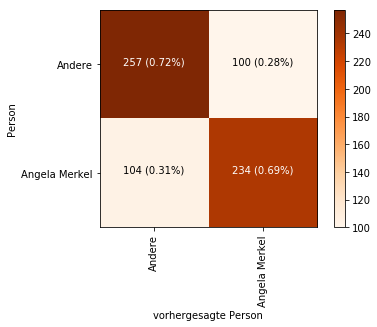

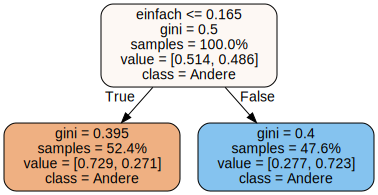

In [19]:
from sklearn.tree import DecisionTreeClassifier

TRAIN_TEST_RATIO = 0.3 # proportion of test data

def make_decision_tree_classifier():
    return DecisionTreeClassifier(splitter="random",
                                  max_depth=1,
                                  criterion="gini")

classifier = make_decision_tree_classifier()

(accuracy, confusion) = train_and_test_with(classifier,
                                            data,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes = categories.unique())
display_decision_tree(classifier)

0.8460431654676259

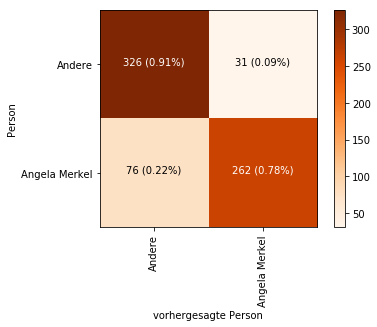

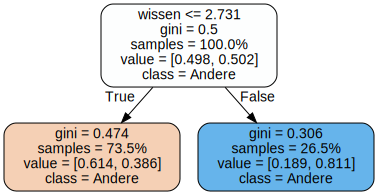

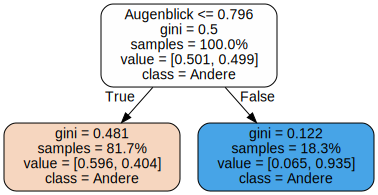

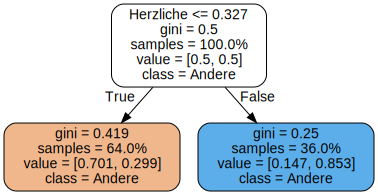

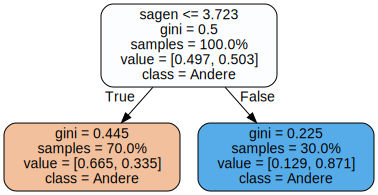

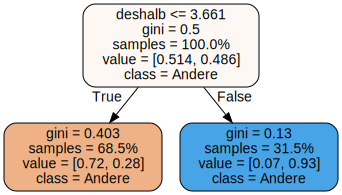

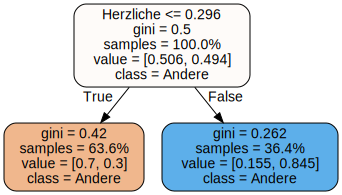

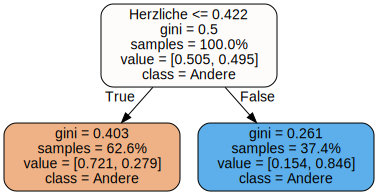

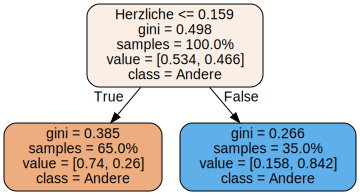

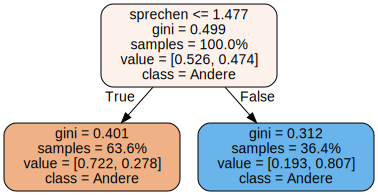

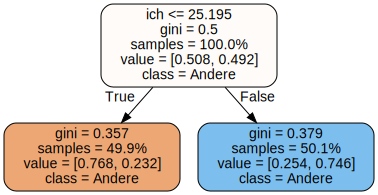

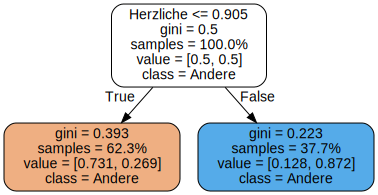

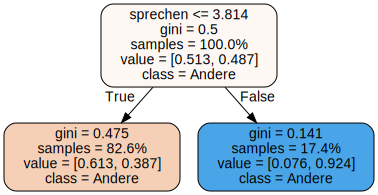

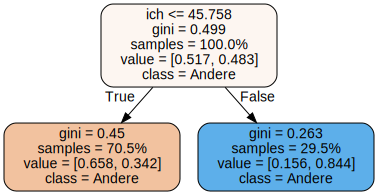

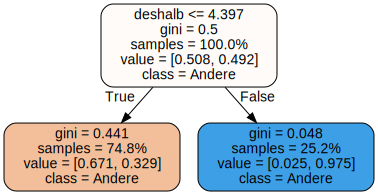

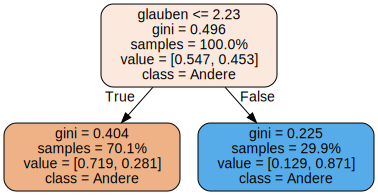

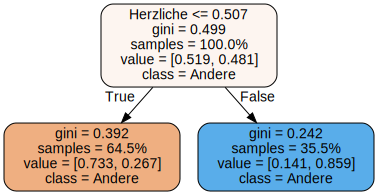

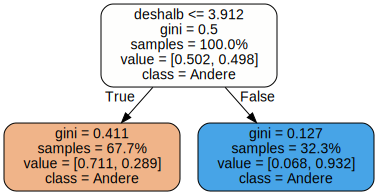

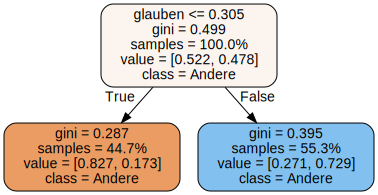

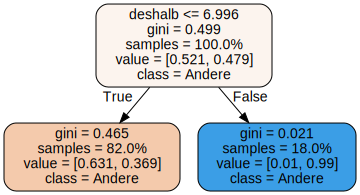

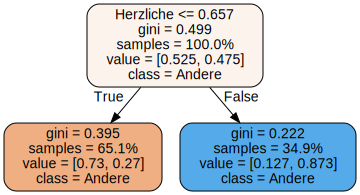

In [20]:
from sklearn.ensemble import BaggingClassifier

BOOST_FACTOR = 20
ALL_CORES = -1

base = make_decision_tree_classifier()
classifier = BaggingClassifier(base_estimator=base,
                               n_estimators=BOOST_FACTOR,
                               n_jobs=ALL_CORES)

(accuracy, confusion) = train_and_test_with(classifier,
                                            data,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes=categories.unique())
for tree in classifier:
    display_decision_tree(tree)

0.9410071942446043

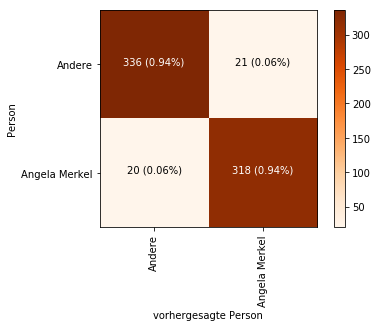

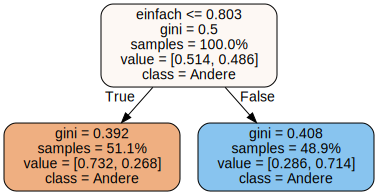

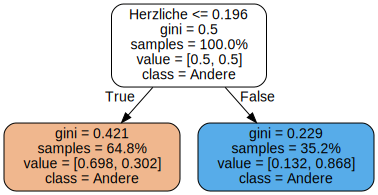

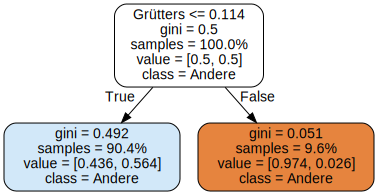

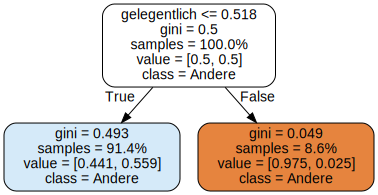

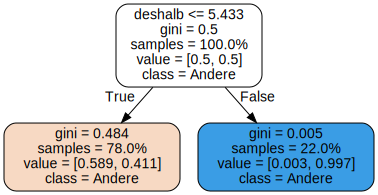

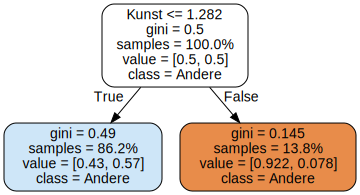

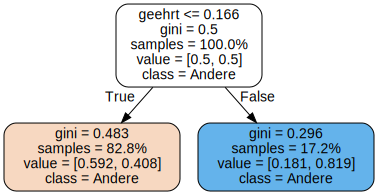

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

base = make_decision_tree_classifier()
classifier = AdaBoostClassifier(base_estimator=base,
                                n_estimators=BOOST_FACTOR)

(accuracy, confusion) = train_and_test_with(classifier,
                                            data,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes=categories.unique())
for tree in classifier:
    display_decision_tree(tree)

In [ ]:
from xgboost import XGBClassifier
import xgboost

base = make_decision_tree_classifier()
classifier = XGBClassifier(max_depth=1,
                           n_estimators = BOOST_FACTOR)

(accuracy, confusion) = train_and_test_with(classifier,
                                            data,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes=categories.unique())
display(graphviz.Source(xgboost.to_graphviz(classifier)))